# Training a PIX2PIX Model using PyTorch / ONNX

This notebook walks you through the steps of training your own image-to-image machine learning model.

Basically all you have to do is put your cursor in a cell and press Shift+Enter. At the end, you can download the latest model from the `output` folder (it will be called something like `generator_epoch_XXX.onnx`).

In [1]:
# Make sure you are connected to a runtime with a GPU
!nvidia-smi -L

GPU 0: NVIDIA RTX 6000 Ada Generation (UUID: GPU-b1d0afef-235b-9d08-2668-64621d6953a8)


#### Uploading your images
Once the cell above has executed, you're connected to a runtime (a machine in the cloud). Click the folder icon in the left sidebar, then drag your ZIP file with files on the sidebar to upload it.

In [3]:
# Install ONNX (not installed by default)
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"
%pip install -q onnx tqdm matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
# Import all other dependencies
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import torchvision.transforms.functional as TF
from PIL import Image
import os
import random
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt
from types import SimpleNamespace
from IPython.display import clear_output

In [5]:
# Check if GPU is available
gpu_available = torch.cuda.is_available()
print("GPU is", "available" if gpu_available else "NOT AVAILABLE")

GPU is available


In [6]:
# Download and unzip the dataset
!curl -O https://algorithmicgaze.s3.amazonaws.com/workshops/2025-raive/patterns_512.zip
!mkdir -p datasets/patterns
!unzip -j -o -qq *.zip -d datasets/patterns
!rm -r datasets/patterns/._*

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  329M  100  329M    0     0  45.0M      0  0:00:07  0:00:07 --:--:-- 51.1M


In [7]:
# Some helper functions for creating/checking directories.
def directory_should_exist(*args):
    dir = os.path.join(*args)
    if not os.path.isdir(dir):
        raise Exception("Path '{}' is not a directory.".format(dir))
    return dir

def ensure_directory(*args):
    dir = os.path.join(*args)
    os.makedirs(dir, exist_ok=True)
    return dir

In [9]:
input_dir = directory_should_exist("datasets/patterns")
output_dir = ensure_directory("output")
sample_interval = 300
snapshot_interval = 1
epochs = 100
batch_size = 8
latent_dim = 128

In [10]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(root_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

In [11]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageDataset(input_dir, transform=transform)
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

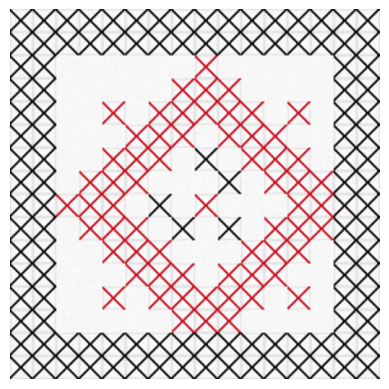

In [12]:
# Show a single image from the dataset
def plot_image(img):
    img = (img + 1) / 2 # Denormalize
    img = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

sample_img = next(iter(dataloader))
plot_image(sample_img[0])

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim=128):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # State: 1024 x 4 x 4
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # State: 512 x 8 x 8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State: 256 x 16 x 16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State: 128 x 32 x 32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State: 64 x 64 x 64
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # State: 32 x 128 x 128
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # State: 16 x 256 x 256
            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 512 x 512
        )

    def forward(self, x):
        return self.main(x)

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3 x 512 x 512
            nn.Conv2d(3, 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 16 x 256 x 256
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 32 x 128 x 128
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 64 x 64 x 64
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 128 x 32 x 32
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 256 x 16 x 16
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 512 x 8 x 8
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # State: 1024 x 4 x 4
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )

    def forward(self, x):
        return self.main(x)

In [15]:
# Define the loss function
criterion = nn.BCELoss()

In [18]:
# Load snapshot if available
def get_latest_snapshot(output_dir):
    snapshots = glob.glob(os.path.join(output_dir, "snapshot_epoch_*.pth"))
    if not snapshots:
        return None
    return max(snapshots, key=os.path.getctime)

def get_latest_generator(output_dir):
    generators = glob.glob(os.path.join(output_dir, "generator_epoch_*.onnx"))
    if not generators:
        return None
    return max(generators, key=os.path.getctime)

In [19]:
def load_snapshot(generator, discriminator, g_optimizer, d_optimizer, snapshot_path):
    checkpoint = torch.load(snapshot_path, map_location=device, weights_only=False)
    generator.load_state_dict(checkpoint["generator"])
    discriminator.load_state_dict(checkpoint["discriminator"])
    g_optimizer.load_state_dict(checkpoint["g_optimizer"])
    d_optimizer.load_state_dict(checkpoint["d_optimizer"])
    start_epoch = int(os.path.basename(snapshot_path).split("_")[2].split(".")[0])
    return start_epoch

In [25]:
def train(generator, discriminator, dataloader, opts):
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Create a fixed noise vector for visualization
    fixed_noise = torch.randn(16, opts.latent_dim, 1, 1, device=device)

    start_epoch = 1
    if not opts.restart:
        latest_snapshot = get_latest_snapshot(opts.output_dir)
        if latest_snapshot:
            start_epoch = load_snapshot(
                generator, discriminator, g_optimizer, d_optimizer, latest_snapshot
            ) + 1
            print(f"Resuming training from epoch {start_epoch}")
        else:
            print("No snapshots found. Starting from scratch.")
    else:
        print("Restarting training from scratch.")

    for epoch in range(start_epoch, start_epoch + opts.epochs):
        for i, real_images in enumerate(tqdm(dataloader)):
            real_images = real_images.to(device)
            b_size = real_images.size(0)

            # Create labels for real and fake images
            real_label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
            fake_label = torch.full((b_size,), 0.0, dtype=torch.float, device=device)

            # --- Train Discriminator ---
            d_optimizer.zero_grad()
            # Real images
            output_real = discriminator(real_images).view(-1)
            d_loss_real = criterion(output_real, real_label)
            d_loss_real.backward()

            # Fake images
            noise = torch.randn(b_size, opts.latent_dim, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach()).view(-1)
            d_loss_fake = criterion(output_fake, fake_label)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            d_optimizer.step()

            # --- Train Generator ---
            g_optimizer.zero_grad()
            output_g = discriminator(fake_images).view(-1)
            g_loss = criterion(output_g, real_label) # Generator wants discriminator to think fakes are real
            g_loss.backward()
            g_optimizer.step()

            if i % opts.sample_interval == 0:
                with torch.no_grad():
                    fake_samples = generator(fixed_noise).detach().cpu()
                clear_output(wait=True)
                print(f"Epoch [{epoch}/{start_epoch + opts.epochs -1}] Batch {i}/{len(dataloader)} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
                
                grid_img = save_image(
                    fake_samples,
                    f"{opts.output_dir}/epoch_{epoch}_iter_{i}.jpg",
                    nrow=4,
                    normalize=True,
                    padding=2
                )
                
                # Create a grid of images
                grid = make_grid(
                    fake_samples, nrow=4, normalize=True, padding=2
                )
                
                # Display the grid
                plt.figure(figsize=(8, 8))
                plt.imshow(grid.permute(1, 2, 0))
                plt.axis('off')
                plt.show()


        if (epoch) % opts.snapshot_interval == 0:
            torch.save({
                "generator": generator.state_dict(),
                "discriminator": discriminator.state_dict(),
                "g_optimizer": g_optimizer.state_dict(),
                "d_optimizer": d_optimizer.state_dict(),
            }, f"{opts.output_dir}/snapshot_epoch_{epoch}.pth")

            # Save to ONNX format
            onnx_path = f"{opts.output_dir}/generator_epoch_{epoch}.onnx"
            generator.eval()
            dummy_input = torch.randn(1, opts.latent_dim, 1, 1, device=device)
            torch.onnx.export(
                generator,
                dummy_input,
                onnx_path,
                export_params=True,
                opset_version=11,
                do_constant_folding=True,
                input_names=["latent_vector"],
                output_names=["output_image"],
                dynamic_axes={"latent_vector": {0: "batch_size"}, "output_image": {0: "batch_size"}},
            )
            print(f"ONNX model exported to {onnx_path}")
            generator.train()

Epoch [15/112] Batch 0/125 | D Loss: 0.0006 | G Loss: 8.3049


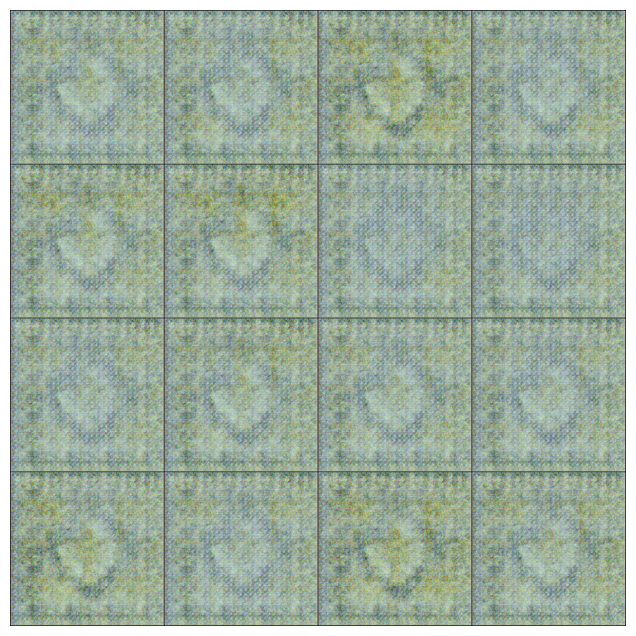

 83%|████████▎ | 104/125 [00:05<00:00, 21.62it/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(z_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

opts = {
    "output_dir": output_dir,
    "sample_interval": sample_interval,
    "snapshot_interval": snapshot_interval,
    "epochs": epochs,
    "restart": False,
    "latent_dim": latent_dim,
}
train(generator, discriminator, dataloader, SimpleNamespace(**opts))

## Optional: Copy the generator model to Google Drive

Downloading the model from the sidebar can be very slow. You can save some time downloading/uploading the generator by using Google Drive. In the next steps we'll connect to Google Drive and upload the generator.

In [ ]:
# Step 1: Mount Google Drive. This will ask for permissions.
from google.colab import drive
drive.mount('/drive')

In [ ]:
# Step 2: Copy the latest .onnx file to Google Drive
import shutil
drive_folder = '/drive/MyDrive/2025-raive'
ensure_directory(drive_folder)
shutil.copy(get_latest_generator(output_dir), drive_folder)